# draft

## import

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time 

## Define some funtions

In [2]:
def f(txt,mapping):
    return [mapping[key] for key in txt] 
soft = torch.nn.Softmax(dim=1)

### 순환신경망 구현2 (with RNNCell) -- 성공 

ref: https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html

`(1)` 숙성네트워크

선언

In [4]:
torch.manual_seed(43052)
rnncell = torch.nn.RNNCell(4,2)

`(2)` 조리네트워크

In [5]:
torch.manual_seed(43052)
cook = torch.nn.Linear(2,4) # 조리담당

`(3)` 손실함수와 옵티마이저 

In [6]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(cook.parameters())) # 우리가 배울것: 숙성하는 방법 + 요리하는 방법 

`(4)` 학습

In [7]:
T = len(x)
t1 = time.time()
for epoc in range(5000):
    ## 1~2
    loss = 0 
    ht = torch.zeros(1,2)
    for t in range(T):
        xt, yt = x[[t]], y[[t]]       
        ht = rnncell(xt,ht) 
        ot = cook(ht)
        loss = loss + loss_fn(ot,yt) 
    loss = loss/T 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time() 
t2-t1

NameError: name 'x' is not defined

`(5)` 시각화 

In [30]:
T = len(x) 
hidden = torch.zeros(T,2) # 599년치 h를 담을 변수 
_water = torch.zeros(1,2) # 맹물 
hidden[[0]] = rnncell(x[[0]],_water) 
for t in range(1,T):
    hidden[[t]] = rnncell(x[[t]],hidden[[t-1]])

In [31]:
yhat = soft(cook(hidden))
yhat 

tensor([[1.6522e-02, 6.2036e-01, 1.0433e-01, 2.5879e-01],
        [9.9965e-01, 6.5788e-05, 1.8450e-05, 2.6785e-04],
        [7.6673e-05, 1.9704e-01, 8.0201e-01, 8.7218e-04],
        ...,
        [7.4634e-05, 1.9501e-01, 8.0407e-01, 8.4751e-04],
        [9.4785e-01, 7.4712e-03, 6.1181e-04, 4.4064e-02],
        [3.6306e-02, 1.2466e-01, 2.8862e-03, 8.3615e-01]],
       grad_fn=<SoftmaxBackward0>)

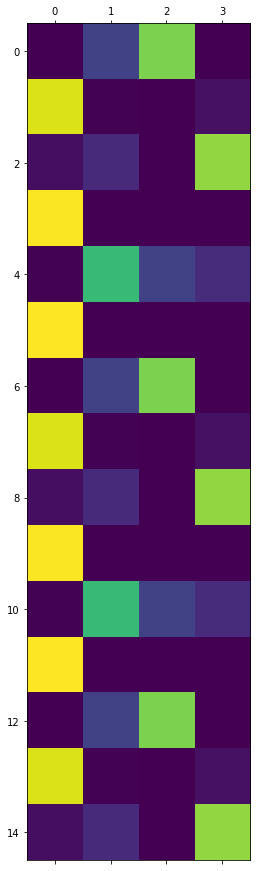

In [32]:
plt.matshow(yhat.data[-15:])

### 순환신경망 구현3 (with RNN) -- 성공 

---

(예비학습)

`-` 아무리 생각해도 yhat구하려면 좀 귀찮음

In [33]:
T = len(x) 
hidden = torch.zeros(T,2) # 599년치 h를 담을 변수 
_water = torch.zeros(1,2) # 맹물 
hidden[[0]] = rnncell(x[[0]],_water) 
for t in range(1,T):
    hidden[[t]] = rnncell(x[[t]],hidden[[t-1]])

In [34]:
soft(cook(hidden))

tensor([[1.6522e-02, 6.2036e-01, 1.0433e-01, 2.5879e-01],
        [9.9965e-01, 6.5788e-05, 1.8450e-05, 2.6785e-04],
        [7.6673e-05, 1.9704e-01, 8.0201e-01, 8.7218e-04],
        ...,
        [7.4634e-05, 1.9501e-01, 8.0407e-01, 8.4751e-04],
        [9.4785e-01, 7.4712e-03, 6.1181e-04, 4.4064e-02],
        [3.6306e-02, 1.2466e-01, 2.8862e-03, 8.3615e-01]],
       grad_fn=<SoftmaxBackward0>)

`-` 이렇게 하면 쉽게(?) 구할 수 있음 

In [35]:
rnn = torch.nn.RNN(4,2) 

In [36]:
rnn.weight_hh_l0.data = rnncell.weight_hh.data 
rnn.bias_hh_l0.data = rnncell.bias_hh.data 
rnn.weight_ih_l0.data = rnncell.weight_ih.data 
rnn.bias_ih_l0.data = rnncell.bias_ih.data 

In [37]:
_water

tensor([[0., 0.]])

In [38]:
soft(cook(rnn(x,_water)[0]))

tensor([[1.6522e-02, 6.2036e-01, 1.0433e-01, 2.5879e-01],
        [9.9965e-01, 6.5788e-05, 1.8450e-05, 2.6785e-04],
        [7.6673e-05, 1.9704e-01, 8.0201e-01, 8.7218e-04],
        ...,
        [7.4634e-05, 1.9501e-01, 8.0407e-01, 8.4751e-04],
        [9.4785e-01, 7.4712e-03, 6.1181e-04, 4.4064e-02],
        [3.6306e-02, 1.2466e-01, 2.8862e-03, 8.3615e-01]],
       grad_fn=<SoftmaxBackward0>)

- 똑같음!

`-` rnn(x,_water)의 결과는 (1) 599년치 간장 (2) 599번째 간장 이다 

In [39]:
rnn(x,_water)

(tensor([[-0.2232,  0.9769],
         [-0.9999, -0.9742],
         [ 0.9154,  0.9992],
         ...,
         [ 0.9200,  0.9992],
         [-0.9978, -0.0823],
         [-0.9154,  0.9965]], grad_fn=<SqueezeBackward1>),
 tensor([[-0.9154,  0.9965]], grad_fn=<SqueezeBackward1>))

***(예비학습결론) torch.nn.RNN(4,2)는 torch.nn.RNNCell(4,2)의 batch 버전이다. (for문이 포함된 버전이다)***

---

torch.nn.RNN(4,2)를 이용하여 구현하자. 

`(1)` 숙성네트워크

선언

In [40]:
rnn = torch.nn.RNN(4,2)

가중치초기화

In [41]:
torch.manual_seed(43052)
_rnncell = rNNCell() 

In [42]:
rnn.weight_ih_l0.data = _rnncell.i2h.weight.data
rnn.bias_ih_l0.data = _rnncell.i2h.bias.data
rnn.weight_hh_l0.data = _rnncell.h2h.weight.data
rnn.bias_hh_l0.data = _rnncell.h2h.bias.data

`(2)` 조리네트워크

In [43]:
torch.manual_seed(43052)
cook = torch.nn.Linear(2,4)

`(3)` 손실함수와 옵티마이저

In [44]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters())) # 우리가 배울것: 숙성하는 방법 + 요리하는 방법 

`(4)` 학습

In [45]:
t1 = time.time()
for epoc in range(5000):
    ## 1
    _water = torch.zeros(1,2)
    hidden, _ = rnn(x,_water)
    output = cook(hidden)
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time() 
t2-t1

63.54761457443237

`(5)` 시각화

In [46]:
yhat = soft(cook(rnn(x,_water)[0]))
yhat

tensor([[1.6522e-02, 6.2036e-01, 1.0433e-01, 2.5879e-01],
        [9.9965e-01, 6.5788e-05, 1.8450e-05, 2.6785e-04],
        [7.6673e-05, 1.9704e-01, 8.0201e-01, 8.7218e-04],
        ...,
        [7.4634e-05, 1.9501e-01, 8.0407e-01, 8.4751e-04],
        [9.4785e-01, 7.4711e-03, 6.1181e-04, 4.4064e-02],
        [3.6306e-02, 1.2466e-01, 2.8862e-03, 8.3615e-01]],
       grad_fn=<SoftmaxBackward0>)

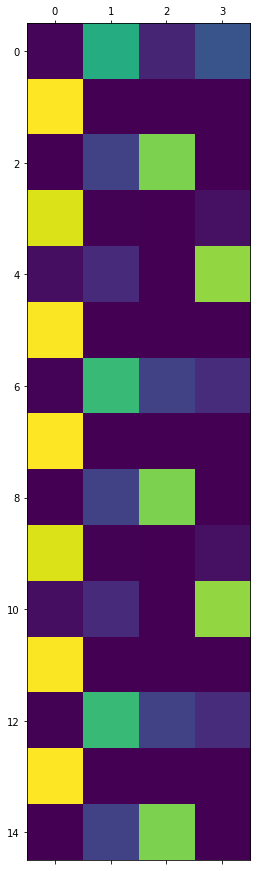

In [47]:
plt.matshow(yhat.data[:15])